In [1]:
import os, glob
import pandas as pd
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import RFormula

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(font_scale=1.5, rc={'text.usetex' : True})

sc = SparkContext('local')
spark = SparkSession(sc)

path = "./input/clean/training_data/"

In [2]:
NC_data = spark.read.csv(path + "NOAA_NC_DAvg_training_data.csv", header=True, inferSchema=True)
NC_data = NC_data.drop(*[t for t in NC_data.columns if t[-1] == 'T']+['date','CLASS'])
NC_data = NC_data.drop(*["MaxTemp", "MinTemp", "MaxRH", "MinRH", "MaxBP", "MinBP", "MaxWSpd", "MinWSpd"])
NC_data.show(5)

+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+
|             ATemp|               RH|                BP|              WSpd|              Wdir|            SDWDir|             TotPrcp|            TotPAR|           AvgVolt|              Temp|
+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+
| 8.296874999999998|71.97916666666667|           1027.75|1.3093750000000004|249.76041666666666|             17.25|                 0.0|204.30624999999995|13.016666666666666|10.641145833333328|
|11.064583333333331|71.29166666666667|1024.4583333333333|1.7385416666666673|249.57291666666666|16.197916666666668|0.003124999999999...|173.65000000000006|12.969791666666666|11.089062499999999|
|15.534374999999997|          71.18

In [3]:
NC_data.select("Temp").describe().show()

+-------+------------------+
|summary|              Temp|
+-------+------------------+
|  count|               882|
|   mean|18.875889341319375|
| stddev| 7.397777596491371|
|    min| 4.209895833333332|
|    max|30.727083333333333|
+-------+------------------+



In [4]:
# vector of features
rf = RFormula(formula="Temp~.")
vector_rf = rf.fit(NC_data).transform(NC_data).select(["features","label"])
rf_n = RFormula(formula="Temp~ATemp")
vector_rf_n = rf_n.fit(NC_data).transform(NC_data).select(["features","label"])
vector_rf_n.show()
vector_rf.show()

+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
| [8.296874999999998]|10.641145833333328|
|[11.064583333333331]|11.089062499999999|
|[15.534374999999997]|12.167708333333321|
|[19.130208333333332]|13.960937499999993|
|[19.667708333333334]|15.548437499999999|
| [9.704166666666664]|13.901562500000011|
|[1.2677083333333334]| 9.498437499999998|
|[2.9770833333333333]|  8.69322916666667|
| [2.934374999999998]| 8.937500000000002|
|[-0.6145833333333...| 6.936458333333337|
|[-2.4343749999999...|4.5239583333333355|
| [7.819791666666666]| 5.978645833333334|
| [9.039583333333335]| 7.492708333333336|
|          [6.878125]| 8.300520833333335|
|[10.276041666666671]| 9.229166666666671|
| [4.164583333333334]| 8.159374999999999|
| [4.756249999999999]| 7.999479166666664|
|[15.266666666666675]|10.765624999999998|
| [6.031250000000003]|10.539583333333328|
|[0.3656250000000001]| 7.708333333333331|
+--------------------+------------

In [5]:
# normalizing data for improved learning algorithms
from pyspark.mllib.util import MLUtils 
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaled_model = scaler.fit(vector_rf)
scaled_model_n = scaler.fit(vector_rf_n).transform(vector_rf_n)
NC_scaled = scaled_model.transform(vector_rf)
NC_scaled.show(10)

+--------------------+------------------+--------------------+
|            features|             label|      scaledFeatures|
+--------------------+------------------+--------------------+
|[8.29687499999999...|10.641145833333328|[0.34938301475925...|
|[11.0645833333333...|11.089062499999999|[0.42974231792886...|
|[15.5343749999999...|12.167708333333321|[0.55952092910718...|
|[19.1302083333333...|13.960937499999993|[0.66392451004113...|
|[19.6677083333333...|15.548437499999999|[0.67953060730704...|
|[9.70416666666666...|13.901562500000011|[0.39024316477135...|
|[1.26770833333333...| 9.498437499999998|[0.14529397532059...|
|[2.97708333333333...|  8.69322916666667|[0.19492499395112...|
|[2.93437499999999...| 8.937500000000002|[0.19368497459472...|
|[-0.6145833333333...| 6.936458333333337|[0.09064239051536...|
+--------------------+------------------+--------------------+
only showing top 10 rows



In [14]:
# splitting data into train and test set
train,test = NC_scaled.randomSplit([0.80,0.20],42069)

In [15]:
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression

glr = GeneralizedLinearRegression(family="gaussian", link="identity",featuresCol="scaledFeatures", maxIter=10, regParam=0)
gl_model = glr.fit(train)
print("Coefficients: "+ str(gl_model.coefficients))
print("Intercept: "+ str(gl_model.intercept))

Coefficients: [31.512822075646636,-0.29681128110527993,3.7450738771855656,-0.07403780362922847,1.5479316168258024,4.3068647979563295,2.5637395868889588,2.1504386648002236,-3.9974438216098793]
Intercept: -2.2942654499179254


In [16]:
from pyspark.ml.evaluation import RegressionEvaluator
gl_pred = gl_model.transform(test)
gl_eval = RegressionEvaluator(predictionCol = "prediction", labelCol="label", metricName = "rmse")
gl_eval.evaluate(gl_pred)

2.0877076290193344

In [17]:
glr = GeneralizedLinearRegression(family="gaussian", link="identity",featuresCol="scaledFeatures", maxIter=10, regParam=0)
gl_model = glr.fit(scaled_model_n)
print("Coefficients: "+ str(gl_model.coefficients))
print("Intercept: "+ str(gl_model.intercept))
gl_pred_n = gl_model.transform(scaled_model_n)
gl_eval = RegressionEvaluator(predictionCol = "prediction", labelCol="label", metricName = "rmse")
gl_eval.evaluate(gl_pred_n)

Coefficients: [31.067073407729985]
Intercept: -0.08395699917400878


2.198854750950632

Text(0, 0.5, 'Water Temperature (C)')

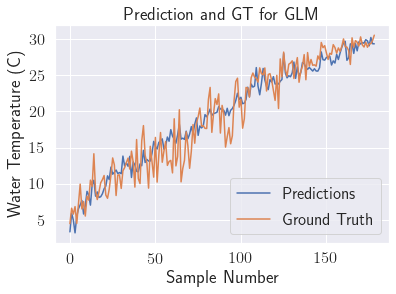

In [27]:
gl_preds = gl_pred.toPandas()
test_pd = test.toPandas()
sns.lineplot(gl_preds.index,gl_preds.prediction, label="Predictions")
sns.lineplot(gl_preds.index, test_pd.label, label = "Ground Truth")
plt.title("Prediction and GT for GLM")
plt.xlabel("Sample Number")
plt.ylabel("Water Temperature (C)")

In [ ]:
gl_preds = gl_pred.toPandas()
test_pd = test.toPandas()
sns.lineplot(gl_preds.index,gl_preds.prediction, label="Predictions")
sns.lineplot(gl_preds.index, test_pd.label, label = "Ground Truth")
plt.title("Prediction and GT for GLM")
plt.xlabel("Sample Number")
plt.ylabel("Water Temperature (C)")

In [21]:
# lasso regression
lasso = LinearRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=10, regParam=0.1, elasticNetParam=1)
lasso_model = lasso.fit(train)
print("Coefficients: "+ str(lasso_model.coefficients))
print("Intercept: "+ str(lasso_model.intercept))

Coefficients: [31.03044139255506,0.0,2.5224115793756905,0.0,0.9165171719868336,3.527326318207467,0.5678532063730692,1.0539245918246887,-2.1316912674082715]
Intercept: -1.7493716597794033


In [22]:
lasso_pred = lasso_model.transform(test)
lasso_eval = RegressionEvaluator(predictionCol = "prediction", labelCol="label", metricName = "rmse")
lasso_eval.evaluate(lasso_pred)

2.089754969285555

In [23]:
# tuning for the best regularization parameter
lr_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
lasso_rmse = []
for i in np.arange(0,2,0.1):
    lr = LinearRegression(featuresCol="scaledFeatures",labelCol="label", maxIter=10, regParam=i, elasticNetParam=1.0)
    lr_model = lr.fit(train)
    lr_pred = lr_model.transform(test)
    lasso_rmse.append(lr_eval.evaluate(lr_pred))

Coefficients: [31.03044139255506,0.0,2.5224115793756905,0.0,0.9165171719868336,3.527326318207467,0.5678532063730692,1.0539245918246887,-2.1316912674082715]
Intercept: -1.7493716597794033


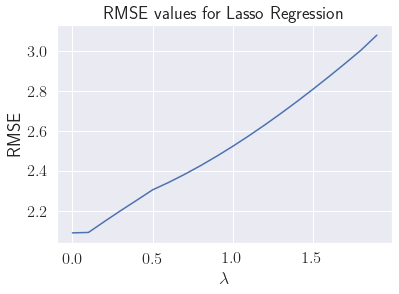

In [24]:
sns.lineplot(np.arange(0,2,0.1), lasso_rmse)
plt.title("RMSE values for Lasso Regression")
plt.xlabel(r"$\lambda$")
plt.ylabel("RMSE")
plt.savefig("./images/RMSE_Lasso.png")
lasso = LinearRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=10, regParam=.1, elasticNetParam=1)
lasso_model = lasso.fit(train)

print("Coefficients: "+ str(lasso_model.coefficients))
print("Intercept: "+ str(lasso_model.intercept))

Text(0.5, 0, 'Sample Number')

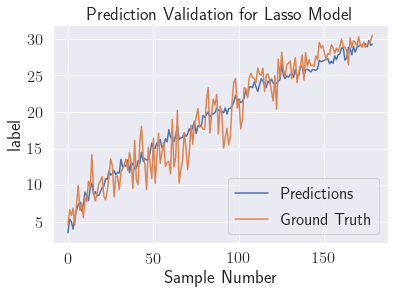

In [26]:
lasso_preds = lasso_pred.toPandas()
sns.lineplot(lasso_preds.index,lasso_preds.prediction, label="Predictions")
sns.lineplot(lasso_preds.index, test_pd.label, label="Ground Truth")
plt.title("Prediction Validation for Lasso Model")
plt.xlabel("Sample Number")

In [28]:
# ridge regression
ridge = LinearRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=10, regParam=.1, elasticNetParam=0)
ridge_model = ridge.fit(train)

print("Coefficients: "+ str(ridge_model.coefficients))
print("Intercept: "+ str(ridge_model.intercept))

Coefficients: [30.541231904153168,0.18680866936736887,3.3551154947154833,-0.21188204460654866,1.5516696125777711,3.9744239032641016,2.6385731019333734,2.903421634348612,-4.493983846787126]
Intercept: -1.6733817860161242


In [29]:
ridge_pred = ridge_model.transform(test)
ridge_eval = RegressionEvaluator(predictionCol = "prediction", labelCol="label", metricName = "rmse")
ridge_eval.evaluate(ridge_pred)

2.101638563582015

In [30]:
# tuning for the best regularization parameter
ridge_rmse = []
for i in np.arange(0,2,0.1):
    lr = LinearRegression(featuresCol="scaledFeatures",labelCol="label", maxIter=10, regParam=i, elasticNetParam=0.0)
    lr_model = lr.fit(train)
    lr_pred = lr_model.transform(test)
    ridge_rmse.append(lr_eval.evaluate(lr_pred))

Coefficients: [30.541231904153168,0.18680866936736887,3.3551154947154833,-0.21188204460654866,1.5516696125777711,3.9744239032641016,2.6385731019333734,2.903421634348612,-4.493983846787126]
Intercept: -1.6733817860161242


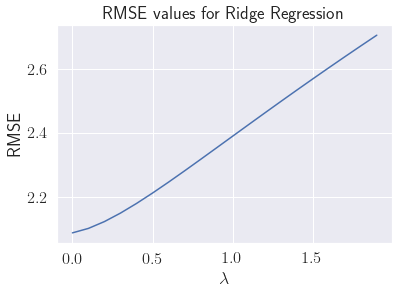

In [31]:
sns.lineplot(np.arange(0,2,0.1), ridge_rmse)
plt.title("RMSE values for Ridge Regression")
plt.xlabel(r"$\lambda$")
plt.ylabel("RMSE")
plt.savefig("./images/RMSE_Ridge.png")
ridge = LinearRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=10, regParam=.1, elasticNetParam=0)
ridge_model = ridge.fit(train)

print("Coefficients: "+ str(ridge_model.coefficients))
print("Intercept: "+ str(ridge_model.intercept))

Text(0.5, 0, 'Index')

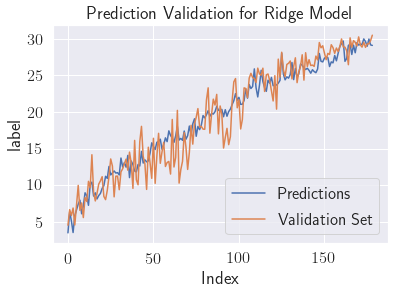

In [32]:
ridge_preds = ridge_pred.toPandas()
sns.lineplot(ridge_preds.index,ridge_preds.prediction, label="Predictions")
sns.lineplot(ridge_preds.index, test_pd.label, label="Validation Set")
plt.title("Prediction Validation for Ridge Model")
plt.xlabel("Index")